In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [2]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [3]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [5]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

In [6]:
onnx_model_path = './onnx/onxx'  # Set to use an already exported model, then skip to the next section.

In [7]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )   

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [8]:
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

In [9]:
image = cv2.imread('images/cats.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

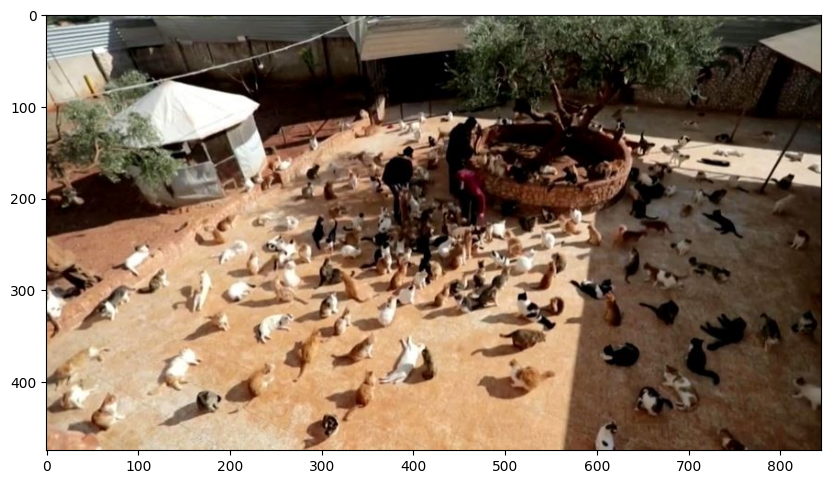

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [11]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [12]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

In [13]:
predictor.set_image(image)

In [14]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [15]:
image_embedding.shape

(1, 256, 64, 64)

In [16]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

In [17]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

In [18]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [19]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [20]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [21]:
masks.shape

(1, 1, 475, 845)

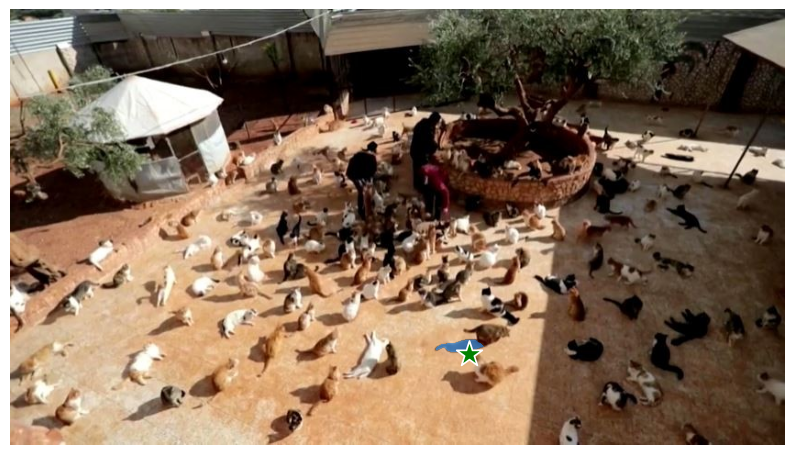

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 